##What does variance of loss represent? 

It measures the degree of dispersion or spread of the loss values around their mean or average.
High variance of loss can indicate that the model is sensitive to small changes in the input data or training process, and may be overfitting to noise or outliers in the training data. This can lead to poor generalization performance on new or unseen data.

Low variance of loss indicates that the model is more robust to such variations and is likely to perform well on new data.

In this notebook we are visualising the variance of loss w.r.t model width. 

Additionaly in the end we would observe 
1. Analysing variance of losses with various batch sizes for SGD optimizes

In [24]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt

# Define device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load MNIST data
train_data = datasets.MNIST(root='./data', train=True, transform=transforms.ToTensor(), download=True)
test_data = datasets.MNIST(root='./data', train=False, transform=transforms.ToTensor(), download=True)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=128, shuffle=False)

##Two layer model architecture as defined in paper 

In [25]:
# Define model architecture and hyperparameters
class TwoLayerNet(nn.Module):
    def __init__(self, hidden_width):
        super(TwoLayerNet, self).__init__()
        self.fc1 = nn.Linear(784, hidden_width)
        self.act1 = nn.Tanh()
        self.fc2 = nn.Linear(hidden_width, 10)  # output layer for 10 classes

    def forward(self, x):
        x = x.view(-1, 784)
        x = self.act1(self.fc1(x))
        x = self.fc2(x)
        return x

In [26]:
lr = 0.5
weight_decay = 1e-6
momentum = 0.9
nesterov = True
# lambda_val = 0.01
sigma = 0.1  # label noise std dev
d_values = [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]

##Note: In both the scenarios, with constant and varying learning rates, there is a noise added as mentioned in paper. 

###Varying learning rate 

##With λ = 0.5/d

In [4]:
variance_values_varying_learning_rate = []
for d in d_values:
    model = TwoLayerNet(d).to(device)
    optimizer = optim.SGD(model.parameters(), lr=lr/d, momentum=momentum, weight_decay=weight_decay)
    loss_fn = nn.CrossEntropyLoss()

    model.train()
    loss_values = []
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        noise = torch.randn_like(target.float()) * sigma
        noisy_target = torch.clamp((target + noise).long(), 0, 9)  # clamp noisy target between 0 and 9
        loss = loss_fn(output, noisy_target)
        loss.backward()
        optimizer.step()
        loss_values.append(loss.item())
    
    variance = torch.var(torch.tensor(loss_values))
    variance_values_varying_learning_rate.append(variance.item())

##Constant learning rate 

##With λ = 0.5


In [6]:
variance_values_constant_learning_rate = []
for d in d_values:
    model = TwoLayerNet(d).to(device)
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
    loss_fn = nn.CrossEntropyLoss()

    model.train()
    loss_values = []
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        noise = torch.randn_like(target.float()) * sigma
        noisy_target = torch.clamp((target + noise).long(), 0, 9)  # clamp noisy target between 0 and 9
        loss = loss_fn(output, noisy_target)
        loss.backward()
        optimizer.step()
        loss_values.append(loss.item())
    
    variance = torch.var(torch.tensor(loss_values))
    variance_values_constant_learning_rate.append(variance.item())

##Results
This is to depict results from paper that variance explodes after d ≥ 200. In contrast, rescaling the learning rate by 1/d results in a constant noise level in training

Note: Results are not exactly matching as in paper 
Few things still to try
1. Use diffrent batch sizes 
2. Using different weight decay values 

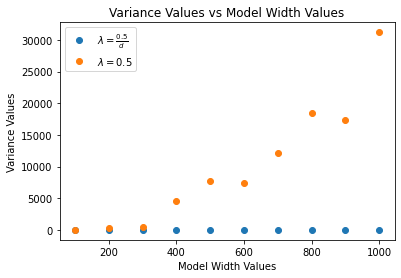

In [15]:
import matplotlib.pyplot as plt

model_width_values = [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]

# plot the data
plt.plot(model_width_values, variance_values_varying_learning_rate,'o', label=r'$\lambda = \frac{0.5}{d}$')
plt.plot(model_width_values, variance_values_constant_learning_rate, 'o', label=r'$\lambda = 0.5$')
plt.legend()
plt.xlabel('Model Width Values')
plt.ylabel('Variance Values')
plt.title('Variance Values vs Model Width Values')
plt.show()

##Additional 

##Analysing variance of losses with various batch sizes for SGD optimizes

In [17]:
variance_values = []
batch_sizes = [32, 64, 128, 256, 512, 1024]

for batch_size in batch_sizes:
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
    variance_values_batch_size = []
    for d in d_values:
        model = TwoLayerNet(d).to(device)
        optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
        loss_fn = nn.CrossEntropyLoss()

        model.train()
        loss_values = []
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = loss_fn(output, target)
            loss.backward()
            optimizer.step()
            loss_values.append(loss.item())

        variance = torch.var(torch.tensor(loss_values))
        variance_values_batch_size.append(variance.item())
    variance_values.append(variance_values_batch_size)

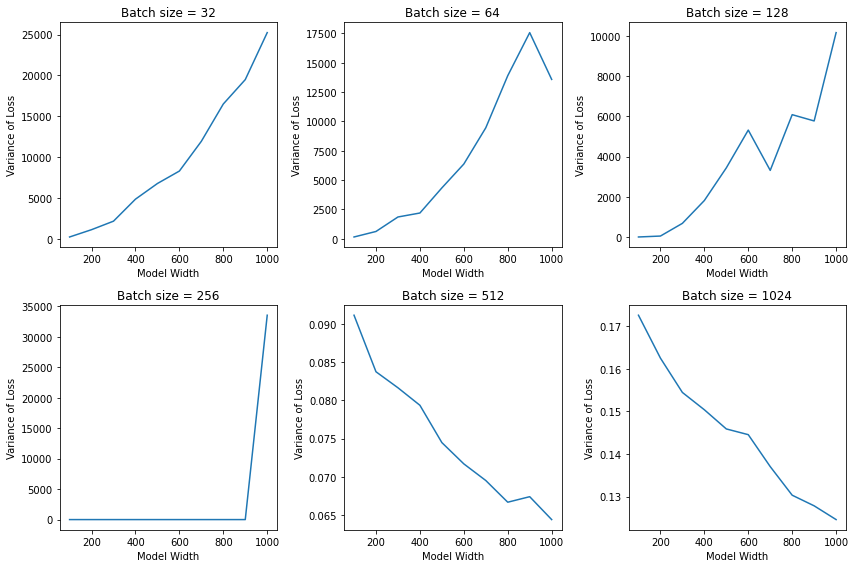

In [23]:
import matplotlib.pyplot as plt

batch_sizes = [32, 64, 128, 256, 512, 1024]
model_width_values = [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]

# Create a 2x3 subplot grid
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(12, 8))

variances = variance_values

# Loop through the batch sizes and plot the data on the corresponding subplot
for i, batch_size in enumerate(batch_sizes):
    row = i // 3
    col = i % 3
    ax = axs[row, col]
    ax.plot(model_width_values, variances[i])
    ax.set_title(f'Batch size = {batch_size}')
    ax.set_xlabel('Model Width')
    ax.set_ylabel('Variance of Loss')

plt.tight_layout()
plt.show()

###Observation: 
In general, larger batch sizes tend to result in a lower variance of loss compared to smaller batch sizes. This is because larger batches provide a more stable estimate of the gradient, which reduces the effect of noisy or random fluctuations in the data. This can lead to a more consistent and stable training process, and can help prevent overfitting to the training data.
